Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

ab_products – подробная информация о продуктах, их название и стоимость

# 1 Выгрузка данных
Выгрузим и посмотрим на наши данные.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, normaltest
import pingouin as pg

In [2]:
# датафрейм с историей заказов пользователей
user_data_df = pd.read_csv('ab_users_data.csv')
user_data_df.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [3]:
# датафрейм с информацией о продуктах
products_df = pd.read_csv ('ab_products.csv')
products_df.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [4]:
# датафрейм с информацией о составе заказа
orders_df = pd.read_csv ('ab_orders.csv')
orders_df.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [5]:
# для того, чтобы обращаться к элементам столбца product_ids как к спискам, уберём скобки и разобьём значения через запятую
orders_df.product_ids = orders_df.product_ids.apply (lambda x: x.replace ('{',''))
orders_df.product_ids = orders_df.product_ids.apply (lambda x: x.replace ('}',''))
orders_df.product_ids = orders_df.product_ids.apply (lambda x: x.split(','))
orders_df.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


Проверим на пропущенные значения

In [6]:
user_data_df.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [7]:
products_df.isna().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


product_id    0
name          0
price         0
dtype: int64

In [8]:
orders_df.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

И посмотрим типы переменных

In [9]:
user_data_df.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [10]:
products_df.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [11]:
orders_df.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

# 2 Определяем метрики эффективности

### Средний чек
Мы можем определить, изменился ли средний чек заказов пользователей. Эта информация даст нам понять, стали ли люди в большем количестве добавлять товары в корзину. Это косвенно скажет о том, что люди добавляют больше разнообразия в покупки.

### Количество уникальных товаров в заказах
Мы можем посчитать, изменилось ли в среднем количество уникальных товаров в заказах. Если люди добавляют разнообразие в свои покупки, значит система рекомендации товаров работает.

### Выручка по пользователям
Можем посчитать, как изменилась выручка по пользователям, стала ли она выше. Положительное изменение скажет о том, что система работает.

# 3 Сравнение средних чеков
Создадим датафрейм, в котором мы сможем сформировать стоимости заказов по разным группам.

In [12]:
# создадим отдельный датафрейм, в котором объединим пользователей, заказы и стоимости продуктов в них
# для этого сначала разобьём списки продуктов заказах на отдельные строчки
orders_explode_df = orders_df.explode ('product_ids').reset_index (drop = True).rename(columns = {'product_ids':'product_id'})
orders_explode_df.product_id = orders_explode_df.product_id.astype('int64')
# объединённый датафрейм
users_orders_products_df = user_data_df.merge (orders_explode_df, on = 'order_id', how = 'inner')\
                                        .merge (products_df, on = 'product_id', how = 'inner')

In [13]:
users_orders_products_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


In [42]:
# посчитаем стоимости заказов в группах
order_price_df = users_orders_products_df.query ('action == "create_order"')\
                                        .groupby(['group', 'order_id'], as_index = False)\
                                        .agg({'price':'sum'})
order_price_df.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


### Проверим наши данные на нормальность распределения

In [15]:
# функцией библиотеки scipy проверяем контрольную группу 0
normaltest (order_price_df.query('group == 0').price)

NormaltestResult(statistic=365.343985499493, pvalue=4.640465524572096e-80)

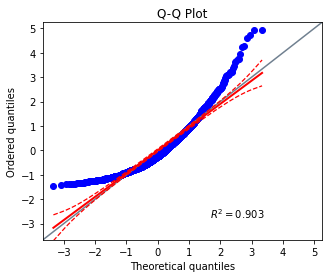

In [16]:
# построим визуализацию для контрольной группы 0
pg.qqplot(order_price_df.query('group == 0').price, dist='norm', confidence=0.95)

In [17]:
# и проверяем тестовую группу 1
normaltest (order_price_df.query('group == 1').price)

NormaltestResult(statistic=971.4468931046567, pvalue=1.129763218272079e-211)

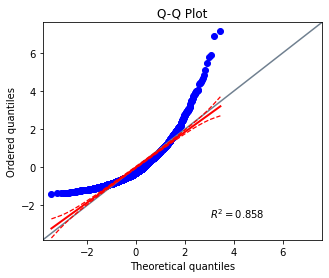

In [18]:
# построим визуализацию для тестовой группы 1
pg.qqplot(order_price_df.query('group == 1').price, dist='norm', confidence=0.95)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


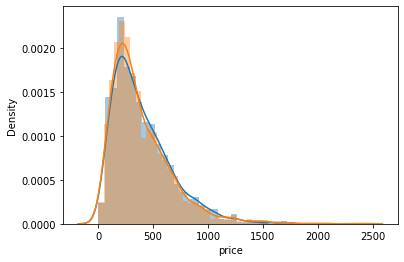

In [19]:
# также построим графики распределения величин в двух группах
sns.distplot (order_price_df.query('group == 0').price)
sns.distplot (order_price_df.query('group == 1').price)

Судя по графикам распределения величин, а также по тестам на нормальность наши рапределения далеки от нормальных. 

Применить t-критерий для сравнения в данном случае мы не можем. Для такого типа распределений подойдёт Bootstrap.

### Сравним между собой средние квадратические значения выборок.

Нулевая гипотеза - средние квадратические значения статистически значимо не различаются.

In [20]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для среднеквадратического
# контрольной группы 0
pg.compute_bootci (x = order_price_df.query('group == 0').price,\
                  func= np.mean)

array([388.11, 413.16])

In [21]:
# считаем доверительный интервал 95% для среднеквадратического
# тестовой группы 1
pg.compute_bootci (x = order_price_df.query('group == 1').price,\
                  func= np.mean)

array([379.48, 401.32])

Доверительные интервалы перекрывают друг друга.

Сравнение среднеквадратических значений показало, что статистически значимых различий между ними нет.

### Попробуем сравнить также медианы.

Нулевая гипотеза - медианы статистически значимо не различаются.

In [22]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для медианы
# контрольной группы 0
pg.compute_bootci (x = order_price_df.query('group == 0').price,\
                  func= np.median)

array([321.3, 348.4])

In [23]:
# считаем доверительный интервал 95% для медианы
# тестовой группы 1
pg.compute_bootci (x = order_price_df.query('group == 1').price,\
                  func= np.mean)

array([378.7 , 400.38])

Сравнение показало, что доверительные интервалы не перекрывают друг друга, а следовательно между медианами есть статистически значимое различие

## Выводы по п.3
Среднеквадратические значения распределений стоимости заказов в контрольной и тестовой группах статистически значимо не различаются.

Медианы по стоимости заказов статистически значимо различны.

# 4 Сравнение количества уникальных товаров в заказах

In [24]:
# возьмём объединённый датафрейм из предыдущего пункта 3
users_orders_products_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


In [39]:
# и посчитаем количество уникальных товаров для каждого заказа в группах
nunique_products_df = users_orders_products_df.query ('action == "create_order"')\
                        .groupby (['group', 'order_id'], as_index = False)\
                        .agg ({'product_id':'nunique'})\
                        .rename (columns = {'product_id':'num_of_uniq_products'})
nunique_products_df.head()

,group,order_id,num_of_uniq_products
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4


### Проверим данные на нормальность

In [40]:
# функцией библиотеки scipy проверяем контрольную группу 0
normaltest (nunique_products_df.query('group == 0').num_of_uniq_products)

NormaltestResult(statistic=33.82934726054547, pvalue=4.50869211002361e-08)

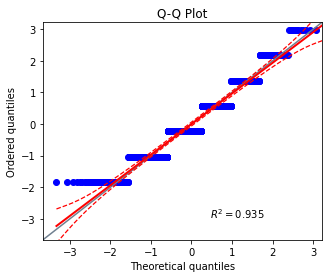

In [41]:
# построим визуализацию для контрольной группы 0
pg.qqplot(nunique_products_df.query('group == 0').num_of_uniq_products, dist='norm', confidence=0.95)

In [28]:
# и проверяем тестовую группу 1
normaltest (nunique_products_df.query('group == 1').num_of_uniq_products)

NormaltestResult(statistic=45.26057253686998, pvalue=1.4852226022198664e-10)

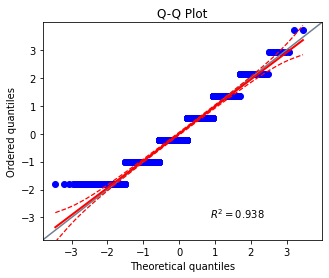

In [29]:
# построим визуализацию для тестовой группы 1
pg.qqplot(nunique_products_df.query('group == 1').num_of_uniq_products, dist='norm', confidence=0.95)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


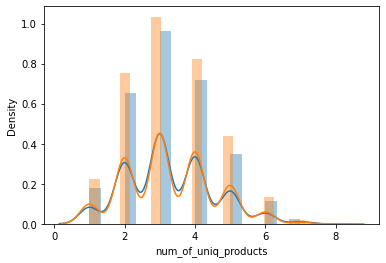

In [30]:
# также построим графики распределения величин в двух группах
sns.distplot (nunique_products_df.query('group == 0').num_of_uniq_products)
sns.distplot (nunique_products_df.query('group == 1').num_of_uniq_products)

Также как и в случае со стоимостями заказов, наши распределения далеки от нормальных, и мы не можем воспользоваться t-тестом для сравнения распределений.

На графике распределений видно, что вариантов по количеству товаров не очень много.

In [31]:
# посчитаем, сколько всего вариантов по количеству уникальных товаров
nunique_products_df.num_of_uniq_products.unique()

array([4, 2, 5, 3, 6, 1, 7, 8])

### Сравнение выборок с помощью критерия хи-квадрат
Вариантов всего восемь. Таким образом мы можем превратить количество уникальных товаров в категориальную переменную и сравнить, есть ли различия между распределениями количества заказов, с помощью критерия хи-квадрат.

Нулевая гипотеза - между распределениями нет статистически значимых различий.

In [32]:
# в новом датафрейме создаём таблицу сопряженности по группам и количеству уникальных товаров,
# а значениями является количество заказов
conjugasy_num_of_products = nunique_products_df.groupby(['group', 'num_of_uniq_products'], as_index = False)\
                    .agg ({'order_id':'count'})\
                    .pivot (index = 'group', columns = 'num_of_uniq_products', values = 'order_id')\
                    .fillna (0)
conjugasy_num_of_products

num_of_uniq_products,1,2,3,4,5,6,7,8
group,,,,,,,,
0,95.0,351.0,516.0,384.0,188.0,62.0,13.0,0.0
1,165.0,553.0,758.0,602.0,321.0,99.0,14.0,2.0


In [33]:
# с помощью функции из библиотеки scipy.stats посчитаем критерий хи-квадрат.
chi2_contingency (conjugasy_num_of_products)

(5.0382204738430065,
 0.655298858050265,
 7,
 array([[101.4649527 , 352.78583556, 497.17826825, 384.78632064,
         198.63715741,  62.83022071,  10.53674509,   0.78049964],
        [158.5350473 , 551.21416444, 776.82173175, 601.21367936,
         310.36284259,  98.16977929,  16.46325491,   1.21950036]]))

Сравнение с помощью критерия хи-квадрат показало, что между распределениями статистически значимых различий нет.

### Сравнение средних с помощью Bootstrap
Обратимся к Bootstrap, чтобы сравнить средние значения распределений.

Нулевая гипотеза - между среднеквадратичными значениями нет статистически значимых различий.

In [34]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для среднеквадратического
# контрольной группы 0
pg.compute_bootci (x = nunique_products_df.query('group == 0').num_of_uniq_products,\
                  func= np.mean)

array([3.22, 3.35])

In [35]:
# считаем доверительный интервал 95% для среднеквадратического
# тестовой группы 1
pg.compute_bootci (x = nunique_products_df.query('group == 1').num_of_uniq_products,\
                  func= np.mean)

array([3.24, 3.34])

Интервалы совпадают, а значит делаем вывод, что между среднеквадратическими значениями статистически значимых различий нет.

Сравним также медианы.

Нулевая гипотеза - между медианами нет статистически значимых различий.

In [36]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для медианы
# контрольной группы 0
pg.compute_bootci (x = nunique_products_df.query('group == 0').num_of_uniq_products,\
                  func= np.median)

array([3., 3.])

In [37]:
# считаем доверительный интервал 95% для медианы
# тестовой группы 1
pg.compute_bootci (x = nunique_products_df.query('group == 1').num_of_uniq_products,\
                  func= np.median)

array([3., 3.])

Нулевая гипотеза не опровергнута и мы можем сказать, что различий нет.

# 5 Сравнение выручки по пользователям
Посчитаем выручку на каждого пользователя в группе, а затем сравним распределения.

In [43]:
# возьмём для работы наш объединённый датафрейм
users_orders_products_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


In [45]:
# посчитаем из него выручки по пользователям в каждой группе
users_revenue_df = users_orders_products_df.query ('action == "create_order"')\
                        .groupby (['group', 'user_id'])\
                        .agg ({'price':'sum'})\
                        .rename (columns = {'price':'revenue'})
users_revenue_df.head()

revenue
group user_id         
0     964        718.9
      966         85.0
      968       1590.7
      969        681.9
      972        546.4

### Проверим на нормальность

In [46]:
# функцией библиотеки scipy проверяем контрольную группу 0
normaltest (users_revenue_df.query('group == 0').revenue)

NormaltestResult(statistic=158.0427044510244, pvalue=4.802449159173491e-35)

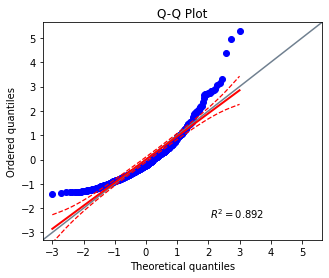

In [47]:
# построим визуализацию для контрольной группы 0
pg.qqplot(users_revenue_df.query('group == 0').revenue, dist='norm', confidence=0.95)

In [48]:
# и проверяем тестовую группу 1
normaltest (users_revenue_df.query('group == 1').revenue)

NormaltestResult(statistic=21.921081107450227, pvalue=1.7373916056009258e-05)

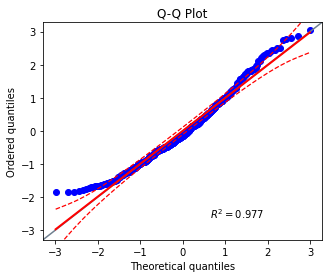

In [49]:
# построим визуализацию для тестовой группы 1
pg.qqplot(users_revenue_df.query('group == 1').revenue, dist='norm', confidence=0.95)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


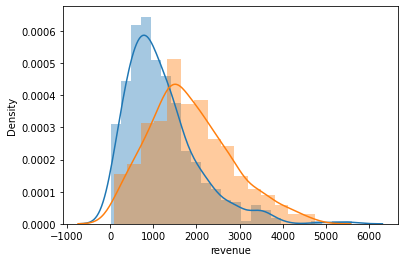

In [50]:
# также построим графики распределения величин в двух группах
sns.distplot (users_revenue_df.query('group == 0').revenue)
sns.distplot (users_revenue_df.query('group == 1').revenue)

Данные распределены не нормально, это не позволяет нам провести t-тест.

На графиках распределения видно, что распределение тестовой группы смещено вправо и немного сглажено. Можно расчитывать, что сравнение средних даст какой-то значимый результат.

### Сравнение средних с помощью Bootstrap

Нулевая гипотеза - между среднеквадратичными значениями нет статистически значимых различий.

In [51]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для среднеквадратического
# контрольной группы 0
pg.compute_bootci (x = users_revenue_df.query('group == 0').revenue,\
                  func= np.mean)

array([1117.81, 1262.31])

In [53]:
# считаем доверительный интервал 95% для среднеквадратического
# тестовой группы 1
pg.compute_bootci (x = users_revenue_df.query('group == 1').revenue,\
                  func= np.mean)

array([1767.85, 1932.01])

Интервалы совсем не совпали, а это значит, что между среднеквадратическими есть статистически значимые различия

Сравним также медианы.

Нулевая гипотеза - между медианами нет статистически значимых различий.

In [56]:
# с помощью метода bootstrap из библиотеки pingoiun посчитаем доверительный интервал 95% для медианы
# контрольной группы 0
pg.compute_bootci (x = users_revenue_df.query('group == 0').revenue,\
                  func= np.median)

array([ 941.6, 1092. ])

In [55]:
# считаем доверительный интервал 95% для медианы
# тестовой группы 1
pg.compute_bootci (x = users_revenue_df.query('group == 1').revenue,\
                  func= np.median)

array([1628.9 , 1809.39])

Интервалы также значительно отличаются, следовательно медианы также значимо различаются.

# Выводы

При сравнении таких метрик, как средний чек заказа и количество уникальных товаров в одном заказе, мы не обнаружили значимых различий. Кроме того, что медианы в выборках по стоимостям заказов всё-таки значимо различаются. Это даёт зацепку, что улучшения всё-таки есть.\
При этом сравнение средних выручек по пользователям даёт нам основание полагать, что выручка на одного пользователя в тестовой группе 1 статистически значимо выше, чем в контрольной группе ноль.\
При этом отсутствие значимых различий в средних чеках и количестве уникальных товаров в одном заказе в группах может объясняться тем, что пользователи не стали покупать больше за один раз, а выручка выросла из-за увеличения частоты заказов, что говорит о эффективности работы рекомендательной системы.\
Можно также в качестве вспомогательной метрики посчитать, действительно ли увеличилась частота заказов, что дополнительно нам скажет в пользу включения рекомендательной системы.

Аналитический вывод - нужно вводить рекомендательную систему в основную версию приложения.